In [5]:
import os, shutil
import io
from io import StringIO
import re
import sys
from contextlib import redirect_stdout
from keras import models
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

import time

import numpy as np
import scipy.optimize as opt
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
from sklearn import metrics
import csv

# my utilities
import cnn_utilities as cn
import uq_utilities_2 as uq

In [2]:
# load trained model and normalization values
my_model = models.load_model("../saved_models/train_extant_R0_sampleRate_migrationRate.hdf5")

mean_sd = pd.read_csv("../saved_models/train_extant_normalization_label_mean_sd.csv", 
                     index_col = 0).to_numpy()

train_means = mean_sd[0,:]
train_sd = mean_sd[1,:]
train_aux_priors_means = train_means[3:,]
train_aux_priors_sd = train_sd[3:,]

num_locs = 5
max_tips = 502


In [3]:
# training and validation data
extant_data = pd.read_csv("../data_files/extant_training_set_0to40.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()

extant_labels = pd.read_csv("../data_files/extant_training_set_0to40_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()



In [47]:
extant_data_mu_ntips = pd.read_table("data_files/labels_and_preds/extant_training_set_0to40_param_values_numtips_propsamp.txt", 
                                  header = 0).to_numpy()
extant_data_mu_ntips = np.column_stack((extant_data_mu_ntips[:,0], extant_data_mu_ntips[:,1]/extant_data_mu_ntips[:,2]))

In [48]:
extant_data_mu_ntips.shape

(111157, 2)

In [21]:
###############################################
# compute and gather auxilliary prior data ##
##############################################
extant_subsample_prop = extant_data[:,(max_tips-1) * 7]
phylocomp_mu = extant_data[:,(max_tips - 3) * 7]
extant_num_tips = cn.get_num_tips(extant_data)

aux_phylocomp = np.vstack((phylocomp_mu, extant_subsample_prop, extant_num_tips,
                          extant_labels[:,8], extant_labels[:,9])).transpose()

norm_aux_phylocomp = cn.normalize(aux_phylocomp, (train_aux_priors_means, train_aux_priors_sd))


# create input tensors
extant_treeLocation_tensor, extant_prior_tensor = cn.create_data_tensors(data = extant_data, 
                                                                                    mu = norm_aux_phylocomp[:,0],
                                                                                    subsample_prop = norm_aux_phylocomp[:,1],
                                                                                    num_tips = norm_aux_phylocomp[:,2],
                                                                                    tmrca = norm_aux_phylocomp[:,3],
                                                                                    mean_bl = norm_aux_phylocomp[:,4],
                                                                                    num_locs = num_locs,
                                                                                    max_tips = max_tips,
                                                                                    cblv_contains_mu_rho = True)

# PREDICT R0, sample rate, migration rate
extant_normalized_preds = my_model.predict([extant_treeLocation_tensor, extant_prior_tensor])

# reversing normalization
cnn_extant_preds = cn.denormalize(extant_normalized_preds, train_means[0:3], train_sd[0:3])
log_preds = cnn_extant_preds
cnn_extant_preds = np.exp(cnn_extant_preds)


In [5]:

############ checking coverage #################


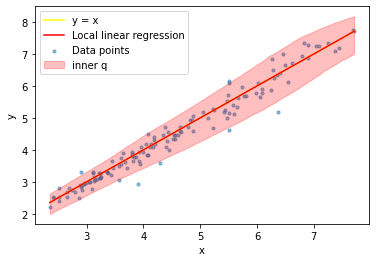

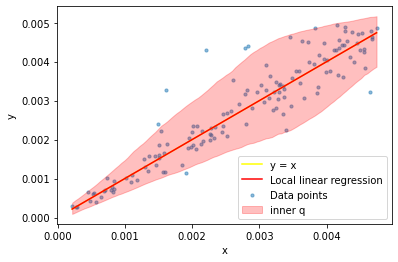

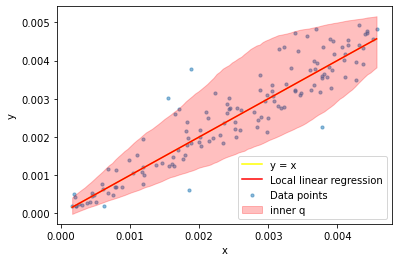

In [47]:
# nn = log_preds.shape[0]
# for i in range(3):
#     for qq in [.95]:
#         f_mean, f_lower_q, f_upper_q = uq.get_CPI(np.exp(log_preds[0:nn,i]), 
#                                                                           extant_labels[0:nn,5+i], 
#                                                                           frac=0.1, inner_quantile=qq)
#         x = cnn_phylocomp_preds[:,i]
#         y = cnn_phylocomp_labels[:,i]
#         i_mean = f_mean(x)
#         i_lower_q = f_lower_q(x)
#         i_upper_q = f_upper_q(x)
#         uq.plot_lowess_fit_quantile(x, y, f_mean, f_lower_q, f_upper_q)

In [ ]:
# make dictionaries containing interval estimating functions
# the keys should be the quantile number
# the values should be (lower_q_fun, upper_q_fun)
train_dat = np.column_stack((log_preds[:,0:3], extant_data_mu_ntips))

nn = log_preds.shape[0]

R0_cpi_fun = {}
delta_cpi_fun = {}
m_cpi_fun = {}

inner_q = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
# inner_q = [0.95]
for q in inner_q:
    start_time = time.time()

    m, lower_q, upper_q = uq.get_CPI(train_dat[0:nn,[0,3,4]],
                                                   np.log(extant_labels[0:nn,5]), 
                                                   frac=0.05, inner_quantile=q)
    R0_cpi_fun[q] = (lower_q, upper_q)
    
    m, lower_q, upper_q = uq.get_CPI(train_dat[0:nn,[1,3,4]],
                                               np.log(extant_labels[0:nn,6]), 
                                               frac=0.05, inner_quantile=q)
    delta_cpi_fun[q] = (lower_q, upper_q)
    
    m, lower_q, upper_q = uq.get_CPI(train_dat[0:nn,[2,3,4]],
                                               np.log(extant_labels[0:nn,7]), 
                                               frac=0.05, inner_quantile=q)
    m_cpi_fun[q] = (lower_q, upper_q)
    
    print(str(q) + " is done.   time = " + str(time.time() - start_time))


0.05 is done.   time = 18252.36346411705
0.1 is done.   time = 18415.69670009613
0.25 is done.   time = 18170.8686978817
0.5 is done.   time = 18067.202995300293


In [314]:
im.reload(uq)

<module 'uq_utilities_2' from 'C:\\Users\\ammon_work\\Desktop\\RESEARCH_PROJECTS\\phylogeo_epi_cnn\\neural_network_dev\\uq_and_adequacy\\uq_utilities_2.py'>

In [156]:
### coverage of CI for test dataset
cnn_phylocomp_preds = pd.read_table("data_files/labels_and_preds/extant_cnn_preds.tsv", header = 0).to_numpy()
cnn_phylocomp_labels = pd.read_table("data_files/labels_and_preds/extant_labels.tsv", header = 0).to_numpy()
cnn_phylocomp_mutips = pd.read_table("data_files/labels_and_preds/extant_phylocomp_param_values_numtips_propsamp.txt", header = 0).to_numpy()

cnn_phylocomp_preds = np.column_stack((np.log(cnn_phylocomp_preds[:,0:3]), cnn_phylocomp_mutips[:,0], cnn_phylocomp_mutips[:,1]/cnn_phylocomp_mutips[:,2]))

In [303]:
# phylocomp true model

# compute coverages
i=0
R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_phylocomp_preds[:,[i,3,4]], cnn_phylocomp_labels[:,i], q_fun = R0_cpi_fun)
i=1
delta_coverage = uq.make_coverage_set(None, None,  
                                   cnn_phylocomp_preds[:,[i,3,4]], cnn_phylocomp_labels[:,i], q_fun = delta_cpi_fun)
i=2
m_coverage = uq.make_coverage_set(None, None,  
                                   cnn_phylocomp_preds[:,[i,3,4]], cnn_phylocomp_labels[:,i], q_fun = m_cpi_fun)

# write to file
df_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((R0_coverage, delta_coverage, m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_cnn_coverage.to_csv('../data_files/cnn_coverage.tsv', sep = "\t", index = True)

# write 95% quantiles to file
phylocomp_R0_95_q = np.array([R0_cpi_fun[0.95][0](cnn_phylocomp_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cnn_phylocomp_preds[:,[0,3,4]])]).transpose()
phylocomp_delta_95_q = np.array([delta_cpi_fun[0.95][0](cnn_phylocomp_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cnn_phylocomp_preds[:,[1,3,4]])]).transpose()
phylocomp_m_95_q = np.array([m_cpi_fun[0.95][0](cnn_phylocomp_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cnn_phylocomp_preds[:,[2,3,4]])]).transpose()

df_cnn_95q = pd.DataFrame(np.hstack((phylocomp_R0_95_q, phylocomp_delta_95_q, phylocomp_m_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_cnn_95q.to_csv('output/phylocomp_cnn_95q.tsv', sep = "\t", index = False)

0.05 finished: 6.521739130434782
0.1 finished: 10.144927536231885
0.25 finished: 27.536231884057973
0.5 finished: 55.79710144927537
0.75 finished: 79.71014492753623
0.9 finished: 92.02898550724638
0.95 finished: 96.37681159420289
0.05 finished: 2.898550724637681
0.1 finished: 9.420289855072465
0.25 finished: 30.434782608695656
0.5 finished: 55.072463768115945
0.75 finished: 73.91304347826086
0.9 finished: 88.40579710144928
0.95 finished: 94.20289855072464
0.05 finished: 5.797101449275362
0.1 finished: 10.869565217391305
0.25 finished: 24.637681159420293
0.5 finished: 49.275362318840585
0.75 finished: 70.28985507246377
0.9 finished: 89.85507246376811
0.95 finished: 94.92753623188406
ERROR! Session/line number was not unique in database. History logging moved to new session 3571


In [162]:
# measure coverage of predictions on out-of-model test data (misspecified)


[13.043478260869565, 0.0, 0.0, 0.0, 0.0, 0.0, 27.536231884057973]

In [307]:
# make coverage sets for R0 misspecification experiments
cnn_miss_r0_preds = pd.read_table("../output/misspec_R0_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_r0_labels = pd.read_table("../output/misspec_R0_labels.tsv", header = 0).to_numpy()
cnn_miss_r0_mutips = pd.read_table("data_files/labels_and_preds/extant_misspec_R0_param_values_numtips_propsamp.txt", 
                                     header = 0).to_numpy()

cnn_miss_r0_preds = np.column_stack((np.log(cnn_miss_r0_preds[:,0:3]), cnn_miss_r0_mutips[:,0], 
                                       cnn_miss_r0_mutips[:,1]/cnn_miss_r0_mutips[:,2]))


i=0
missR0_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_r0_preds[:,[i,3,4]], cnn_miss_r0_labels[:,i], q_fun = R0_cpi_fun)
i=1
missR0_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_r0_preds[:,[i,3,4]], cnn_miss_r0_labels[:,i], q_fun = delta_cpi_fun)
i=2
missR0_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_r0_preds[:,[i,3,4]], cnn_miss_r0_labels[:,i], q_fun = m_cpi_fun)

df_missR0_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((missR0_R0_coverage, missR0_delta_coverage, missR0_m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_missR0_cnn_coverage.to_csv('../data_files/missR0_cnn_coverage.tsv', sep = "\t", index = True)

# write 95% quantiles to file
missR0_R0_95_q = np.array([R0_cpi_fun[0.95][0](cnn_miss_r0_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cnn_miss_r0_preds[:,[0,3,4]])]).transpose()
missR0_delta_95_q = np.array([delta_cpi_fun[0.95][0](cnn_miss_r0_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cnn_miss_r0_preds[:,[1,3,4]])]).transpose()
missR0_m_95_q = np.array([m_cpi_fun[0.95][0](cnn_miss_r0_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cnn_miss_r0_preds[:,[2,3,4]])]).transpose()

df_cnn_95q = pd.DataFrame(np.hstack((missR0_R0_95_q, missR0_delta_95_q, missR0_m_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_cnn_95q.to_csv('output/missR0_cnn_95q.tsv', sep = "\t", index = False)

0.05 finished: 0.0
0.1 finished: 0.0
0.25 finished: 1.0752688172043012
0.5 finished: 7.526881720430108
0.75 finished: 15.053763440860216
0.9 finished: 24.731182795698924
0.95 finished: 35.483870967741936
0.05 finished: 5.376344086021505
0.1 finished: 6.451612903225806
0.25 finished: 22.58064516129032
0.5 finished: 37.634408602150536
0.75 finished: 65.59139784946237
0.9 finished: 80.64516129032258
0.95 finished: 87.09677419354838
0.05 finished: 2.1505376344086025
0.1 finished: 5.376344086021505
0.25 finished: 12.903225806451612
0.5 finished: 23.655913978494624
0.75 finished: 45.16129032258064
0.9 finished: 61.29032258064516
0.95 finished: 73.11827956989248


In [309]:
# make coverage sets for delta misspecification experiments

cnn_miss_delta_preds = pd.read_table("../output/misspec_delta_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_delta_labels = pd.read_table("../output/misspec_delta_labels.tsv", header = 0).to_numpy()
cnn_miss_delta_mutips = pd.read_table("data_files/labels_and_preds/extant_misspec_delta_param_values_numtips_propsamp.txt", 
                                     header = 0).to_numpy()

cnn_miss_delta_preds = np.column_stack((np.log(cnn_miss_delta_preds[:,0:3]), cnn_miss_delta_mutips[:,0], 
                                       cnn_miss_delta_mutips[:,1]/cnn_miss_delta_mutips[:,2]))

i=0
missDelta_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_delta_preds[:,[i,3,4]], cnn_miss_delta_labels[:,i], q_fun = R0_cpi_fun)
i=1
missDelta_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_delta_preds[:,[i,3,4]], cnn_miss_delta_labels[:,i], q_fun = delta_cpi_fun)
i=2
missDelta_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_delta_preds[:,[i,3,4]], cnn_miss_delta_labels[:,i], q_fun = m_cpi_fun)

df_missDelta_missR0_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((missDelta_R0_coverage, missDelta_delta_coverage, missDelta_m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_missDelta_missR0_cnn_coverage.to_csv('../data_files/missDelta_cnn_coverage.tsv', sep = "\t", index = True)

# write 95% quantiles to file
missDeltaR0_95_q = np.array([R0_cpi_fun[0.95][0](cnn_miss_delta_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cnn_miss_delta_preds[:,[0,3,4]])]).transpose()
missDeltadelta_95_q = np.array([delta_cpi_fun[0.95][0](cnn_miss_delta_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cnn_miss_delta_preds[:,[1,3,4]])]).transpose()
missDeltam_95_q = np.array([m_cpi_fun[0.95][0](cnn_miss_delta_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cnn_miss_delta_preds[:,[2,3,4]])]).transpose()

df_cnn_95q = pd.DataFrame(np.hstack((missDeltaR0_95_q, missDeltadelta_95_q, missDeltam_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_cnn_95q.to_csv('output/missDeltacnn_95q.tsv', sep = "\t", index = False)

0.05 finished: 8.47457627118644
0.1 finished: 12.711864406779661
0.25 finished: 28.8135593220339
0.5 finished: 44.06779661016949
0.75 finished: 64.40677966101694
0.9 finished: 82.20338983050848
0.95 finished: 88.98305084745762
0.05 finished: 0.0
0.1 finished: 0.847457627118644
0.25 finished: 5.084745762711865
0.5 finished: 23.728813559322035
0.75 finished: 39.83050847457627
0.9 finished: 50.847457627118644
0.95 finished: 60.16949152542372
0.05 finished: 3.389830508474576
0.1 finished: 5.084745762711865
0.25 finished: 12.711864406779661
0.5 finished: 32.20338983050847
0.75 finished: 49.152542372881356
0.9 finished: 66.94915254237289
0.95 finished: 77.96610169491525


In [310]:
# make coverage sets for m misspecification experiments
cnn_miss_m_preds = pd.read_table("../output/misspec_migration_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_m_labels = pd.read_table("../output/misspec_migration_labels.tsv", header = 0).to_numpy()
cnn_miss_m_mutips = pd.read_table("data_files/labels_and_preds/extant_misspec_m_param_values_numtips_propsamp.txt", 
                                     header = 0).to_numpy()

cnn_miss_m_preds = np.column_stack((np.log(cnn_miss_m_preds[:,0:3]), cnn_miss_m_mutips[:,0], 
                                       cnn_miss_m_mutips[:,1]/cnn_miss_m_mutips[:,2]))

i=0
missM_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_m_preds[:,[i,3,4]], cnn_miss_m_labels[:,i], q_fun = R0_cpi_fun)
i=1
missM_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_m_preds[:,[i,3,4]], cnn_miss_m_labels[:,i], q_fun = delta_cpi_fun)
i=2
missM_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_m_preds[:,[i,3,4]], cnn_miss_m_labels[:,i], q_fun = m_cpi_fun)

df_missM_missR0_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((missM_R0_coverage, missM_delta_coverage, missM_m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_missM_missR0_cnn_coverage.to_csv('../data_files/missM_cnn_coverage.tsv', sep = "\t", index = True)

# write 95% quantiles to file
missM_R0_95_q = np.array([R0_cpi_fun[0.95][0](cnn_miss_m_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cnn_miss_m_preds[:,[0,3,4]])]).transpose()
missM_delta_95_q = np.array([delta_cpi_fun[0.95][0](cnn_miss_m_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cnn_miss_m_preds[:,[1,3,4]])]).transpose()
missM_m_95_q = np.array([m_cpi_fun[0.95][0](cnn_miss_m_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cnn_miss_m_preds[:,[2,3,4]])]).transpose()

df_cnn_95q = pd.DataFrame(np.hstack((missM_R0_95_q, missM_delta_95_q, missM_m_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_cnn_95q.to_csv('output/missM_cnn_95q.tsv', sep = "\t", index = False)

0.05 finished: 3.3333333333333335
0.1 finished: 8.88888888888889
0.25 finished: 27.77777777777778
0.5 finished: 48.888888888888886
0.75 finished: 73.33333333333333
0.9 finished: 90.0
0.95 finished: 94.44444444444444
0.05 finished: 3.3333333333333335
0.1 finished: 10.0
0.25 finished: 23.333333333333332
0.5 finished: 47.77777777777778
0.75 finished: 67.77777777777779
0.9 finished: 92.22222222222223
0.95 finished: 96.66666666666667
0.05 finished: 4.444444444444445
0.1 finished: 7.777777777777778
0.25 finished: 15.555555555555555
0.5 finished: 27.77777777777778
0.75 finished: 54.44444444444444
0.9 finished: 66.66666666666666
0.95 finished: 74.44444444444444


In [311]:
# make coverage sets for numloc misspecification experiments

cnn_miss_loc_preds = pd.read_table("../output/misspec_numloc_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_loc_labels = pd.read_table("../output/misspec_numloc_labels.tsv", header = 0).to_numpy()
cnn_miss_loc_mutips = pd.read_table("data_files/labels_and_preds/extant_misspec_numloc_param_values_numtips_propsamp.txt", 
                                     header = 0).to_numpy()

cnn_miss_loc_preds = np.column_stack((np.log(cnn_miss_loc_preds[:,0:3]), cnn_miss_loc_mutips[:,0], 
                                       cnn_miss_loc_mutips[:,1]/cnn_miss_loc_mutips[:,2]))

i=0
missNumLoc_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_loc_preds[:,[i,3,4]], cnn_miss_loc_labels[:,i], q_fun = R0_cpi_fun)
i=1
missNumLoc_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_loc_preds[:,[i,3,4]], cnn_miss_loc_labels[:,i], q_fun = delta_cpi_fun)
i=2
missNumLoc_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_loc_preds[:,[i,3,4]], cnn_miss_loc_labels[:,i], q_fun = m_cpi_fun)

df_missNumLoc_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((missNumLoc_R0_coverage, missNumLoc_delta_coverage, missNumLoc_m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_missNumLoc_cnn_coverage.to_csv('../data_files/missNumLoc_cnn_coverage.tsv', sep = "\t", index = True)

# write 95% quantiles to file
missNumLoc_R0_95_q = np.array([R0_cpi_fun[0.95][0](cnn_miss_loc_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cnn_miss_loc_preds[:,[0,3,4]])]).transpose()
missNumLoc_delta_95_q = np.array([delta_cpi_fun[0.95][0](cnn_miss_loc_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cnn_miss_loc_preds[:,[1,3,4]])]).transpose()
missNumLoc_m_95_q = np.array([m_cpi_fun[0.95][0](cnn_miss_loc_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cnn_miss_loc_preds[:,[2,3,4]])]).transpose()

df_cnn_95q = pd.DataFrame(np.hstack((missNumLoc_R0_95_q, missNumLoc_delta_95_q, missNumLoc_m_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_cnn_95q.to_csv('output/missNumLoc_cnn_95q.tsv', sep = "\t", index = False)

0.05 finished: 4.201680672268908
0.1 finished: 6.722689075630252
0.25 finished: 23.52941176470588
0.5 finished: 47.05882352941176
0.75 finished: 68.90756302521008
0.9 finished: 86.5546218487395
0.95 finished: 92.43697478991596
0.05 finished: 2.5210084033613445
0.1 finished: 6.722689075630252
0.25 finished: 16.80672268907563
0.5 finished: 43.69747899159664
0.75 finished: 70.58823529411765
0.9 finished: 86.5546218487395
0.95 finished: 93.27731092436974
0.05 finished: 3.361344537815126
0.1 finished: 5.042016806722689
0.25 finished: 15.966386554621847
0.5 finished: 34.45378151260504
0.75 finished: 57.98319327731093
0.9 finished: 69.74789915966386
0.95 finished: 75.63025210084034
ERROR! Session/line number was not unique in database. History logging moved to new session 3573


In [313]:
# make coverage sets for tree misspecification experiments

cnn_miss_tree_preds = pd.read_table("../output/misspec_tree_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_tree_labels = pd.read_table("../output/misspec_tree_labels.tsv", header = 0).to_numpy()
cnn_miss_tree_mutips = pd.read_table("data_files/labels_and_preds/extant_misspec_tree_param_values_numtips_propsamp.txt", 
                                     header = 0).to_numpy()

cnn_miss_tree_preds = np.column_stack((np.log(cnn_miss_tree_preds[:,0:3]), cnn_miss_tree_mutips[:,0], 
                                       cnn_miss_tree_mutips[:,1]/cnn_miss_tree_mutips[:,2]))

i=0
missTree_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_tree_preds[:,[i,3,4]], cnn_miss_tree_labels[:,i], q_fun = R0_cpi_fun)
i=1
missTree_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_tree_preds[:,[i,3,4]], cnn_miss_tree_labels[:,i], q_fun = delta_cpi_fun)
i=2
missTree_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_tree_preds[:,[i,3,4]], cnn_miss_tree_labels[:,i], q_fun = m_cpi_fun)

df_missTree_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((missTree_R0_coverage, missTree_delta_coverage, missTree_m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_missTree_cnn_coverage.to_csv('../data_files/missTree_cnn_coverage.tsv', sep = "\t", index = True)

# write 95% quantiles to file
missTree_R0_95_q = np.array([R0_cpi_fun[0.95][0](cnn_miss_tree_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cnn_miss_tree_preds[:,[0,3,4]])]).transpose()
missTree_delta_95_q = np.array([delta_cpi_fun[0.95][0](cnn_miss_tree_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cnn_miss_tree_preds[:,[1,3,4]])]).transpose()
missTree_m_95_q = np.array([m_cpi_fun[0.95][0](cnn_miss_tree_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cnn_miss_tree_preds[:,[2,3,4]])]).transpose()

df_cnn_95q = pd.DataFrame(np.hstack((missTree_R0_95_q, missTree_delta_95_q, missTree_m_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_cnn_95q.to_csv('output/missTree_cnn_95q.tsv', sep = "\t", index = False)

0.05 finished: 2.9702970297029703
0.1 finished: 2.9702970297029703
0.25 finished: 20.792079207920793
0.5 finished: 31.683168316831683
0.75 finished: 54.45544554455446
0.9 finished: 72.27722772277228
0.95 finished: 78.21782178217822
0.05 finished: 4.9504950495049505
0.1 finished: 5.9405940594059405
0.25 finished: 16.831683168316832
0.5 finished: 34.65346534653465
0.75 finished: 53.46534653465347
0.9 finished: 69.3069306930693
0.95 finished: 79.20792079207921
0.05 finished: 5.9405940594059405
0.1 finished: 9.900990099009901
0.25 finished: 19.801980198019802
0.5 finished: 38.613861386138616
0.75 finished: 67.32673267326733
0.9 finished: 87.12871287128714
0.95 finished: 92.07920792079209
